<a href="https://colab.research.google.com/github/GustavBoye/DRED_Autoencoder/blob/main/IncludeGoogleTrends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

DAYS = 32
HISTORY = 30



def load_csv_trend(file_path):
    data = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(float(row[1]))  # Converting to float for numerical processing
    return data

# Helper function for normalization
def normalize_min_max(data):
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

# Define input tickers
input_tickers = [
    'IAG', 'DRD', 'GOLD', 'NEM', 'GLD', 'AEM', 'PAAS', 'AU', 'KGC', 'WPM', 'AG', 'NG', 'HMY', 'GMAB', 'NMM', 'CSIQ', 'MAG', 'CSCO', 'FSM', 'OR', 'PYPL',
    'SEDG', 'FSLR', 'ENPH', 'JKS', 'RUN', 'NEE', 'CWEN', 'LNTH',
    'MSFT', 'NVDA', 'AMD', 'INTC', 'GOOG', 'META', 'TSM', 'INTU', 'UMC', 'MU', 'ORCL', 'ASML', 'DELL', 'TXN', 'QRVO', 'BIDU', 'SMCI',
    'TSLA', 'ALB', 'LTBR', 'CAT', 'BWXT', 'BA', 'SIEGY', 'SQM', 'MA', 'MCD', 'AVXL', 'SRTS',
    'HDSN', 'CCJ', 'AMZN', 'WELL', 'MPLX', 'TSE', 'ELD', 'UTHR', 'ABT', 'JNJ', 'BABA', 'JPM', 'SB', 'TER', 'ARKQ', 'BLX', 'NRG', 'LIT', 'FLXS', 'BAESY', 'STE', 'IBM', 'KO', 'PEP', 'GS', 'V'
]

import time
import pandas as pd # Import pandas here
import yfinance as yf

def batch_download(tickers, start, end, interval, batch_size=5):
    all_data = {}
    for i in range(0, len(tickers), batch_size):
        batch_tickers = tickers[i:i + batch_size]
        print(f"Downloading data for: {batch_tickers}")

        # Try to download the data for this batch
        try:
            data = yf.download(batch_tickers, start=start, end=end, interval=interval)['Close']
            all_data.update(data.to_dict())
        except Exception as e:
            print(f"Error downloading data for {batch_tickers}: {e}")
            time.sleep(0.4)  # Wait for a bit before retrying if an error occurs

        time.sleep(0.5)  # Sleep between batches to avoid hitting rate limits
    return pd.DataFrame(all_data)

# Fetch stock data in batches
data = batch_download(input_tickers, start="2017-01-01", end="2025-02-22", interval="1d")
data_volume = batch_download(input_tickers, start="2017-01-01", end="2025-02-22", interval="1d")
data_trends = load_csv_trend("Tesla_Trend.csv", stretch_to=len(data))

# Preprocess the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

scaler_vol = MinMaxScaler()
data_scaled_vol = scaler_vol.fit_transform(data_volume)


# Function to create supervised learning dataset
def create_dataset(data, vol, trends, time_steps=0, future_steps=0):
    X, y = [], []
    for i in range(len(data) - time_steps - future_steps):

        data_to_insert_trends = normalize_min_max(trends[i:i + time_steps])
        data_to_insert_a = normalize_min_max(data[i:i + time_steps])
        data_to_insert_b = normalize_min_max(vol[i:i + time_steps])
        data_to_insert = np.concatenate([data_to_insert_a, data_to_insert_b], axis=0)
        X.append([data_to_insert, data_to_insert_trends])

        future_prices = data[i + time_steps:i + time_steps + future_steps]
        current_price = data[i + time_steps - 1]
        future_average_price = np.mean(future_prices, axis=0)
        target = future_average_price - current_price
        y.append(target)
    return np.array(X), np.array(y)

# Function to create inverted dataset
def create_inverted_dataset(data, vol, trends, time_steps=0, future_steps=0):
    inverted_data = 1-data
    inverted_trends_data = 1-trends
    X, y = [], []
    for i in range(len(inverted_data) - time_steps - future_steps):

        data_to_insert_trends = normalize_min_max(inverted_trends_data[i:i + time_steps])
        data_to_insert_a = normalize_min_max(inverted_data[i:i + time_steps])
        data_to_insert_b = normalize_min_max(vol[i:i + time_steps])
        data_to_insert = np.concatenate([data_to_insert_a, data_to_insert_b], axis=0)
        X.append([data_to_insert, data_to_insert_trends])

        future_prices = inverted_data[i + time_steps:i + time_steps + future_steps]
        current_price = inverted_data[i + time_steps - 1]
        future_average_price = np.mean(future_prices, axis=0)
        target = future_average_price - current_price
        y.append(target)
    return np.array(X), np.array(y)

# Prepare dataset (200-day version)
X_s, y_s = create_dataset(data_scaled, data_scaled_vol, time_steps=HISTORY, future_steps=DAYS)
X_inv_s, y_inv_s = create_inverted_dataset(data_scaled, data_scaled_vol, time_steps=HISTORY, future_steps=DAYS)
X_combined_s = np.concatenate((X_s, X_inv_s), axis=0)
y_combined_s = np.concatenate((y_s, y_inv_s), axis=0)

def build_model(shape1, shape2):
    input_layer = tf.keras.layers.Input(shape=(shape1, shape2))
    x = tf.keras.layers.SpatialDropout1D(0.3)(input_layer)
    x = tf.keras.layers.Conv1D(64, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.002))(x)
    #x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x1 = tf.keras.layers.Conv1D(64, 3, strides=1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.002))(x)
    x1 = tf.keras.layers.Activation('gelu')(x1)
    x = x + x1  # Residual connection
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.002))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x1 = tf.keras.layers.Conv1D(128, 3, strides=1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.002))(x)
    x1 = tf.keras.layers.Activation('gelu')(x1)
    x = x + x1  # Residual connection
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.002))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv1D(128, 3, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.002))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Flatten()(x)

    dense1 = tf.keras.layers.Dense(256, activation='gelu')(x)
    dense1 = tf.keras.layers.Dropout(0.2)(dense1)
    dense2 = tf.keras.layers.Dense(256, activation='gelu')(dense1)
    dense = dense1+dense2


    output = tf.keras.layers.Dense(len(input_tickers))(dense)

    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model


# Training setup
num_models = 1
early_stopping = EarlyStopping(monitor='val_loss', patience=32, min_delta=1e-4, restore_best_weights=True, mode='min', verbose=1)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=16, verbose=1)

import random
# Train the ensemble (200-day version)
ensemble = []
for i in range(num_models):
    print(f"Training model {i+1}/{num_models} for {DAYS}-day prediction...")
    model = build_model(X_combined_s.shape[1], X_combined_s.shape[2])
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_combined_s, y_combined_s, epochs=25, batch_size=16, validation_split=0.3, verbose=1, callbacks=[early_stopping, lr_scheduler])
    ensemble.append(model)

# Predictions (200-day version)
predictions = {ticker: [] for ticker in input_tickers}
for idx, ticker in enumerate(input_tickers):
    predictions[ticker] = np.mean([m(X_combined_s[:1]).numpy()[:, idx] for m in ensemble], axis=0)

# Plot predictions
fig, ax = plt.subplots(figsize=(18, 10))
tickers_range = np.arange(len(input_tickers))
pred_days = np.array([predictions[ticker] for ticker in input_tickers]).flatten()
ax.bar(tickers_range, pred_days, color='blue', width=0.6, label='200-Day Prediction')

ax.set_title("200-Day Predictions for All Tickers", fontsize=16)
ax.set_xlabel("Tickers", fontsize=14)
ax.set_ylabel("Predicted Change", fontsize=14)
ax.set_xticks(tickers_range)
ax.set_xticklabels(input_tickers, rotation=45, fontsize=10)
ax.legend(title="Prediction Length", fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

import pandas as pd

# Convert predictions dictionary to DataFrame
predictions_df = pd.DataFrame.from_dict(predictions, orient='index', columns=['{DAYS}-Day Prediction'])

# Save as CSV
predictions_df.to_csv(f"predictions_{DAYS}.csv")

# Download in Colab
from google.colab import files
files.download(f"predictions_{DAYS}.csv")

In [20]:
"""DOWNLOAD THE STOCK DATA"""

import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import csv

DAYS = 30
HISTORY = 60

# Helper function for normalization
def normalize_min_max(data):
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

# Define input tickers
input_tickers = [
    'IAG', 'DRD', 'GOLD', 'NEM', 'GLD', 'AEM', 'PAAS', 'AU', 'KGC']

import time
import pandas as pd # Import pandas here
import yfinance as yf

def batch_download(tickers, start, end, interval, batch_size=5):
    all_data = {}
    for i in range(0, len(tickers), batch_size):
        batch_tickers = tickers[i:i + batch_size]
        print(f"Downloading data for: {batch_tickers}")

        # Try to download the data for this batch
        try:
            data = yf.download(batch_tickers, start=start, end=end, interval=interval)['Close']
            all_data.update(data.to_dict())
        except Exception as e:
            print(f"Error downloading data for {batch_tickers}: {e}")
            time.sleep(0.4)  # Wait for a bit before retrying if an error occurs

        time.sleep(0.5)  # Sleep between batches to avoid hitting rate limits
    return pd.DataFrame(all_data)

# Fetch stock data in batches
data = batch_download(input_tickers, start="2017-01-01", end="2025-02-22", interval="1d")
data_volume = batch_download(input_tickers, start="2017-01-01", end="2025-02-22", interval="1d")

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  4 of 4 completed


[*******************   40%                       ]  2 of 5 completed

[*********************100%***********************]  5 of 5 completed
[                       0%                       ]

[*********************100%***********************]  4 of 4 completed


multiTimeline (16).csv
multiTimeline (19).csv
multiTimeline (17).csv
multiTimeline (18).csv
multiTimeline (20).csv
multiTimeline (15).csv


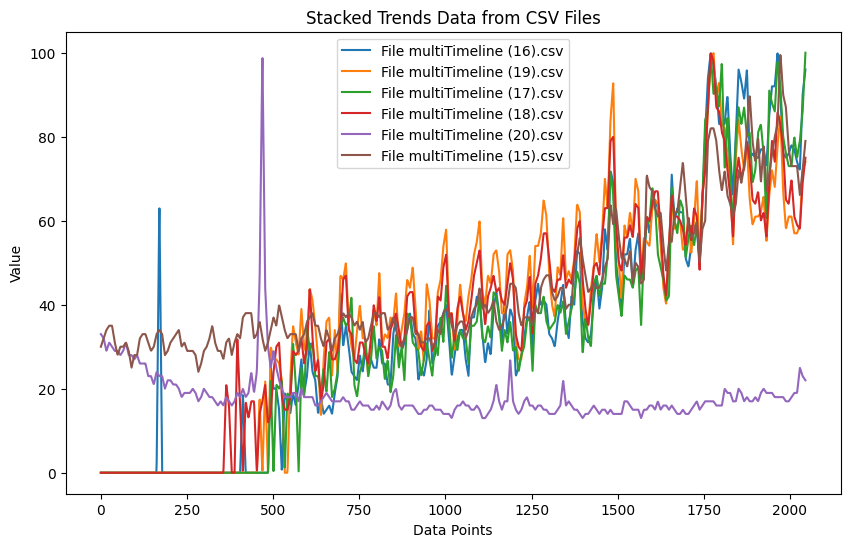

Shape of stacked trend data: (6, 2046)


In [29]:
"""DOWNLOAD THE TREND DATA"""

import os
import csv
import numpy as np
import matplotlib.pyplot as plt

def load_csv_trend_from_folder_with_skip(folder_path, target_size=None):
    all_data = []

    # List all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)

            # Load the trend data from each CSV file
            file_data = []
            with open(file_path, newline='', encoding='utf-8') as csvfile:
                reader = csv.reader(csvfile)

                # Skip the first 3 rows
                next(reader)  # Skipping row 1
                next(reader)  # Skipping row 2
                next(reader)  # Skipping row 3

                # Now read the remaining rows as data
                for row in reader:
                    # Assuming that data starts from the 2nd column (index 1) as per your example
                    file_data.append(float(row[1]))  # Converting to float for numerical processing

            # Append the file's data as a new row in the all_data list
            all_data.append(file_data)

    # Convert list of lists into a numpy array (stacking files as rows)
    all_data = np.array(all_data)

    # If a target size is provided, stretch or interpolate the data along the appropriate axis
    if target_size:
        trend_len = all_data.shape[1]  # Number of columns (data points per file)
        if trend_len != target_size:
            # Perform interpolation to match the desired size
            # Reshape all_data to 2D before interpolation
            all_data_2d = all_data.reshape(-1, trend_len)

            # Interpolate each row (file's data) individually
            interpolated_trends = []
            for row in all_data_2d:
                interpolated_row = np.interp(np.linspace(0, trend_len - 1, target_size), np.arange(trend_len), row)
                interpolated_trends.append(interpolated_row)

            # Convert the list of interpolated rows back to a numpy array
            interpolated_trends = np.array(interpolated_trends)
            return interpolated_trends

    return all_data

def print_file_names_in_folder(folder_path):
    files = []
    # List all files and directories in the given folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        # Check if it's a file (not a directory)
        if os.path.isfile(file_path) and file_name.endswith('.csv'):
            files.append(file_name)
            print(file_name)
    return files

# Load all CSV files from the folder
folder_path = "Trends"
csv_files = print_file_names_in_folder(folder_path)

# Load and stack all trend data
all_trends = load_csv_trend_from_folder_with_skip(folder_path, target_size=len(data))

# Plot the stacked data (visualizing each file's data in separate lines)
plt.figure(figsize=(10, 6))

# Plot each file's trend data as a separate line
for idx, file_data in enumerate(all_trends):
    plt.plot(file_data, label=f'File {csv_files[idx]}')

plt.title('Stacked Trends Data from CSV Files')
plt.xlabel('Data Points')
plt.ylabel('Value')
plt.legend()
plt.show()

# Print shape of the stacked data
print(f"Shape of stacked trend data: {all_trends.shape}")


In [63]:
# Preprocess the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

scaler_vol = MinMaxScaler()
data_scaled_vol = scaler_vol.fit_transform(data_volume)

def create_dataset(data, vol, trends, time_steps=0, future_steps=0, inverted=False):
    print(data.shape) #(2046, 9)
    print(trends.shape) # (6, 2046)

    # Transpose trends to change its shape from (6, 2046) to (2046, 6)
    trends = trends.T

    print(trends.shape)  # Now it will print (2046, 6)



    if inverted==True:
      inverted_data = 1-data
      inverted_trends_data = 1-trends
    else:
      inverted_data = data
      inverted_trends_data = trends
    X, y = [], []
    for i in range(len(inverted_data) - time_steps - future_steps):

        data_to_insert_trends = normalize_min_max(inverted_trends_data[i:i + time_steps])
        print(f"data_to_insert_trends {data_to_insert_trends.shape}")
        data_to_insert_a = normalize_min_max(inverted_data[i:i + time_steps])
        print(f"data_to_insert_a {data_to_insert_a.shape}")
        data_to_insert_b = normalize_min_max(vol[i:i + time_steps])
        print(f"vol {data_to_insert_b.shape}")

        data_to_insert = np.concatenate([data_to_insert_a, data_to_insert_b], axis=1)
        print(f"data_to_insert {data_to_insert.shape}")
        data_to_insert_final = np.concatenate([data_to_insert, data_to_insert_trends], axis=1)
        print(f"data_to_insert_final {data_to_insert_final.shape}")


        X.append(data_to_insert)

        future_prices = inverted_data[i + time_steps:i + time_steps + future_steps]
        current_price = inverted_data[i + time_steps-1]
        future_average_price = np.mean(future_prices, axis=0)
        target = future_average_price - current_price
        y.append(target)
    return np.array(X), np.array(y)

print(DAYS)
X_s, y_s = create_dataset(data_scaled, data_scaled_vol, all_trends, time_steps=HISTORY, future_steps=DAYS)
X_inv_s, y_inv_s = create_dataset(data_scaled, data_scaled_vol, all_trends, time_steps=HISTORY, future_steps=DAYS, inverted=True)
X_combined_s = np.concatenate((X_s, X_inv_s), axis=0)
y_combined_s = np.concatenate((y_s, y_inv_s), axis=0)

30
(2046, 9)
(6, 2046)
(2046, 6)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)

<ipython-input-35-a0d6b2b612d9>:17: RuntimeWarning: invalid value encountered in divide
  return (data - min_val) / (max_val - min_val)


Streaming af output blev afkortet til de sidste 5000 linjer.
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
data_to_insert_final (60, 24)
data_to_insert_trends (60, 6)
data_to_insert_a (60, 9)
vol (60, 9)
data_to_insert (60, 18)
d